In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import yfinance as yf
from scipy.optimize import minimize
import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 10000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [3]:
tickers = yf.Tickers(['GOOG', 'JPM', 'UL', 'JNJ'])
start = datetime(2016,1,1)
end = datetime(2021,1,1)
#weekly_prices = tickers.history(period = '5Y', interval = '1wk')
weekly_prices = pd.read_csv('weekly_prices.csv')
print(weekly_prices.head())
selected = list(weekly_prices.columns[1:])
weekly_returns = weekly_prices[selected].pct_change()
print(weekly_returns.head())

  Unnamed: 0        GOOG         JNJ        JPM         UL
0  7/18/2016  742.739990  109.458664  55.803799  39.638615
1  7/25/2016  768.789978  109.633766  55.742798  39.817242
2   8/1/2016  782.219971  108.767044  57.773132  39.272850
3   8/3/2016         NaN         NaN        NaN        NaN
4   8/8/2016  783.219971  107.874100  56.919170  40.101429
       GOOG       JNJ       JPM        UL
0       NaN       NaN       NaN       NaN
1  0.035073  0.001600 -0.001093  0.004506
2  0.017469 -0.007906  0.036423 -0.013672
3  0.000000  0.000000  0.000000  0.000000
4  0.001278 -0.008210 -0.014781  0.021098


In [4]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [5]:
port_return = return_portfolios(mean_returns, cov_matrix)
print(port_return.head())
weights, returns, risks = optimal_portfolio(weekly_returns[1:])

    Returns  Volatility  GOOG Weight  JNJ Weight  JPM Weight  UL Weight
0  0.002482    0.022598     0.132040    0.053891    0.136693   0.677376
1  0.003279    0.022003     0.305763    0.325016    0.226702   0.142519
2  0.003091    0.021273     0.305467    0.404424    0.148331   0.141778
3  0.002993    0.023540     0.070223    0.348377    0.412264   0.169136
4  0.002791    0.020887     0.171893    0.424321    0.197436   0.206350
     pcost       dcost       gap    pres   dres
 0: -3.1378e-03 -1.0049e+00  1e+00  3e-16  3e+00
 1: -3.1417e-03 -1.4865e-02  1e-02  2e-16  3e-02
 2: -3.4364e-03 -4.9616e-03  2e-03  1e-16  4e-03
 3: -4.6478e-03 -5.2580e-03  6e-04  7e-16  7e-04
 4: -4.8381e-03 -4.8474e-03  9e-06  1e-16  1e-05
 5: -4.8432e-03 -4.8433e-03  9e-08  3e-16  1e-07
 6: -4.8433e-03 -4.8433e-03  9e-10  1e-16  1e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1350e-03 -1.0049e+00  1e+00  0e+00  3e+00
 1: -3.1388e-03 -1.4862e-02  1e-02  8e-17  3e-02
 2: -3.

<ipython-input-6-ebe78c52113b>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


Text(0.5, 1.0, 'Risks vs Returns of Random portfolios')

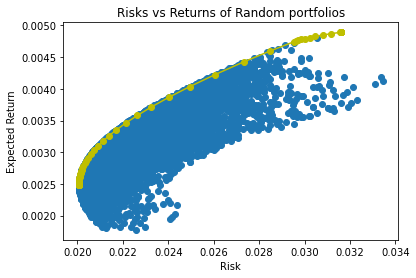

In [6]:
plt.scatter(port_return.Volatility, port_return.Returns)
plt.plot(risks,returns,'y-o')
ax = plt.subplot()
ax.set_xlabel('Risk')
ax.set_ylabel('Expected Return')
plt.title('Risks vs Returns of Random portfolios')